# Credit-Risk-Analysis

In [75]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.metrics import sensitivity_specificity_support

In [76]:
#importing the final dataframe from previous workbook
credx_final_df = pd.read_csv("credx_final.csv", sep=",")

credx_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69864 entries, 0 to 69863
Data columns (total 16 columns):
30DPD_12months              69864 non-null float64
30DPD_6months               69864 non-null float64
60DPD_12months              69864 non-null float64
60DPD_6months               69864 non-null float64
90DPD_12months              69864 non-null float64
90DPD_6months               69864 non-null float64
PLtrades_opened_12months    69864 non-null float64
PLtrades_opened_6months     69864 non-null float64
avg_ccutil_12months         69864 non-null float64
inquiries_12months          69864 non-null float64
inquiries_6months           69864 non-null float64
outstanding_balance         69864 non-null float64
total_trades                69864 non-null float64
trades_opened_12months      69864 non-null float64
trades_opened_6months       69864 non-null float64
defaulted                   69864 non-null float64
dtypes: float64(16)
memory usage: 8.5 MB


### Using both Demographic and Credit Bureau data

#### Test Train split

In [77]:
# splitting the final dataset 
credx_train, credx_test, def_train, def_test = train_test_split(credx_final_df.drop("defaulted", axis = 1), credx_final_df['defaulted'], train_size=0.7, test_size=0.3, random_state=100)

But before moving ahead, we will need to take care of the class imbalance in the training set.

#### Class Imbalance check

Let's handle the class imbalance we saw in the dataset.

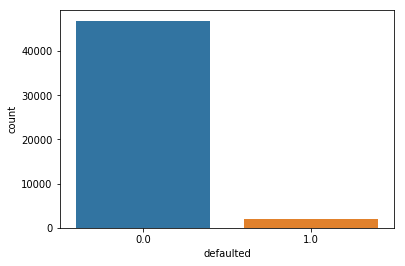

In [78]:
# plotting the classes
sns.countplot(x=def_train)
plt.show()

In [79]:
# importing the library
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE

# create an object using smote to handle the class imbalance by over sampling
smt = SMOTE()

# fitting the object to generate data
credx_train_osX, def_train_osY = smt.fit_sample(credx_train, def_train)
credx_train_os = pd.concat([pd.DataFrame(credx_train_osX), pd.DataFrame(def_train_osY)], axis=1)
credx_train_os.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,0
0,-0.376395,-0.386796,-0.351921,-0.336371,-0.356637,-0.260685,-0.686488,-0.649191,-0.870432,-0.828287,-0.320076,-0.135622,-0.877731,-0.893936,-0.543248,0.0
1,-0.376395,-0.386796,-0.351921,-0.336371,-0.356637,-0.260685,0.500166,0.438391,0.502987,0.588355,0.328824,0.294589,-0.065828,-0.054283,-0.000353,0.0
2,0.972734,0.951744,0.752695,0.933733,0.885508,0.810130,0.426105,0.438391,0.502987,0.588355,0.216134,0.432984,0.512570,0.575732,0.435079,1.0
3,-0.376395,-0.386796,-0.351921,-0.336371,-0.356637,-0.260685,-0.686488,-0.649191,-0.870432,-0.828287,-0.320076,-0.832159,-0.877731,-0.893936,-0.543248,0.0
4,-0.376395,-0.386796,-0.351921,-0.336371,-0.356637,-0.260685,-0.686488,-0.649191,-0.726765,-0.828287,-0.320076,-0.832159,-0.877731,-0.893936,-0.543248,0.0


In [80]:
# putting the column names back
credx_train_os.columns = credx_train.columns.append(pd.Index(['defaulted']))
credx_train_os.head()

,30DPD_12months,30DPD_6months,60DPD_12months,60DPD_6months,90DPD_12months,90DPD_6months,PLtrades_opened_12months,PLtrades_opened_6months,avg_ccutil_12months,inquiries_12months,inquiries_6months,outstanding_balance,total_trades,trades_opened_12months,trades_opened_6months,defaulted
0,-0.376395,-0.386796,-0.351921,-0.336371,-0.356637,-0.260685,-0.686488,-0.649191,-0.870432,-0.828287,-0.320076,-0.135622,-0.877731,-0.893936,-0.543248,0.0
1,-0.376395,-0.386796,-0.351921,-0.336371,-0.356637,-0.260685,0.500166,0.438391,0.502987,0.588355,0.328824,0.294589,-0.065828,-0.054283,-0.000353,0.0
2,0.972734,0.951744,0.752695,0.933733,0.885508,0.810130,0.426105,0.438391,0.502987,0.588355,0.216134,0.432984,0.512570,0.575732,0.435079,1.0
3,-0.376395,-0.386796,-0.351921,-0.336371,-0.356637,-0.260685,-0.686488,-0.649191,-0.870432,-0.828287,-0.320076,-0.832159,-0.877731,-0.893936,-0.543248,0.0
4,-0.376395,-0.386796,-0.351921,-0.336371,-0.356637,-0.260685,-0.686488,-0.649191,-0.726765,-0.828287,-0.320076,-0.832159,-0.877731,-0.893936,-0.543248,0.0


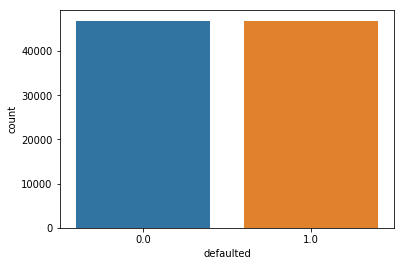

In [81]:
# plotting the classes
sns.countplot(x='defaulted', data=credx_train_os)
plt.show()

In [82]:
# putting the dataset back into the variables
credx_train = credx_train_os.drop('defaulted', axis=1)
def_train = credx_train_os['defaulted']

print(credx_train.head())
print(def_train.head())

   30DPD_12months  30DPD_6months  60DPD_12months  60DPD_6months  \
0       -0.376395      -0.386796       -0.351921      -0.336371   
1       -0.376395      -0.386796       -0.351921      -0.336371   
2        0.972734       0.951744        0.752695       0.933733   
3       -0.376395      -0.386796       -0.351921      -0.336371   
4       -0.376395      -0.386796       -0.351921      -0.336371   

   90DPD_12months  90DPD_6months  PLtrades_opened_12months  \
0       -0.356637      -0.260685                 -0.686488   
1       -0.356637      -0.260685                  0.500166   
2        0.885508       0.810130                  0.426105   
3       -0.356637      -0.260685                 -0.686488   
4       -0.356637      -0.260685                 -0.686488   

   PLtrades_opened_6months  avg_ccutil_12months  inquiries_12months  \
0                -0.649191            -0.870432           -0.828287   
1                 0.438391             0.502987            0.588355   
2          

#### Logistic Regression

In [83]:
# Fitting the model
logitreg = LogisticRegression(class_weight='balanced')
logitreg.fit(credx_train, def_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [84]:
# Logistic regression model
logitmod1 = sm.GLM(def_train,(sm.add_constant(credx_train)), family = sm.families.Binomial())
logitmod1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              defaulted   No. Observations:                93680
Model:                            GLM   Df Residuals:                    93664
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -60286.
Date:                Sat, 21 Dec 2019   Deviance:                   1.2057e+05
Time:                        14:44:55   Pearson chi2:                 9.36e+04
No. Iterations:                     5   Covariance Type:             nonrobust
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0027      0.007     -0.398      0.691      -0.016       0.011
30DPD_12months               0.1156      0.047      2.465      0.014       0.024       0.208
30DPD_6months                0.4079      0.060      6.830      0.000       0.291       0.525
60DPD_12months              -0.2821      0.044     -6.412      0.000      -0.368      -0.196
60DPD_6months                0.0515      0.061      0.849      0.396      -0.067       0.170
90DPD_12months              -0.0804      0.035     -2.305      0.021      -0.149      -0.012
90DPD_6months                0.0827      0.045      1.838      0.066      -0.005       0.171
PLtrades_opened_12months    -0.0772      0.033     -2.308      0.021      -0.143      -0.012
PLtrades_opened_6months      0.0515      0.032      1.588      0.112      -0.012       0.115
avg_ccutil_12months          0.4681      0.018     26.179      0.000       0.433       0.503
inquiries_12months           0.2768      0.022     12.316      0.000       0.233       0.321
inquiries_6months           -0.0230      0.027     -0.839      0.402      -0.077       0.031
outstanding_balance          0.2350      0.028      8.417      0.000       0.180       0.290
total_trades                -0.0413      0.037     -1.115      0.265      -0.114       0.031
trades_opened_12months       0.1693      0.041      4.137      0.000       0.089       0.249
trades_opened_6months        0.1325      0.032      4.134      0.000       0.070       0.195
============================================================================================
"""

#### Principal Component Analysis

In [85]:
pca = PCA()
pca.fit(credx_train)
credx_pca = pca.fit_transform(credx_train)

In [86]:
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0      63.75
1      80.18
2      84.51
3      88.58
4      91.05
5      92.75
6      94.28
7      95.60
8      96.65
9      97.46
10     98.18
11     98.84
12     99.38
13     99.80
14    100.00
dtype: float64


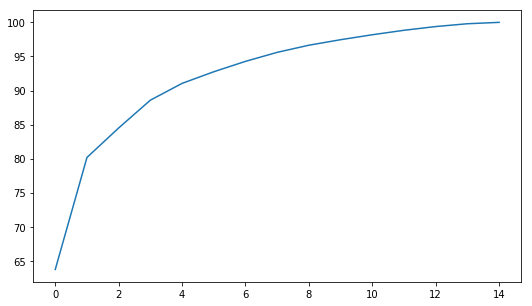

In [87]:
# plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(175/20,100/20)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)

In [88]:
# create pipeline
PCA_VARS = 12
step = [("pca", PCA(n_components=PCA_VARS)),
         ("logistic", LogisticRegression(class_weight='balanced'))
        ]
pipeln = Pipeline(step)

In [89]:
# fit model
pipeln.fit(credx_train, def_train)

# check score on training data
pipeln.score(credx_train, def_train)

0.6316182749786508

In [90]:
# predict default on test data
def_pred = pipeln.predict(credx_test)

# create confusion matrix
cm = confusion_matrix(def_test, def_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(def_test, def_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
def_pred_prob = pipeln.predict_proba(credx_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(def_test, def_pred_prob),2))

[[11647  8430]
 [  273   610]]
Sensitivity: 	0.69
Specificity: 	0.58
AUC:    	 0.68


#### Grid search CV

In [93]:
# PCA
pca = PCA()

# create pipeline
step = [("pca", pca),
         ("logistic", LogisticRegression(class_weight='balanced'))
        ]

# compile pipeline
pca_logistic = Pipeline(step)

# hyperparameter space
params = {'pca__n_components': [9,10,11,12,13,14], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
fold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=pca_logistic, cv=fold, param_grid=params, scoring='roc_auc')

In [94]:
# fit model
model.fit(credx_train, def_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'pca__n_components': [9, 10, 11, 12, 13, 14], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [95]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.6765073287171985
Best hyperparameters:  {'logistic__C': 0.1, 'logistic__penalty': 'l1', 'pca__n_components': 13}


In [96]:
# predict default on test data
def_pred = model.predict(credx_test)

# create confusion matrix
cm = confusion_matrix(def_test, def_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(def_test, def_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
def_pred_prob = model.predict_proba(credx_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(def_test, def_pred_prob),2))

[[11632  8445]
 [  273   610]]
Sensitivity: 	0.69
Specificity: 	0.58
AUC:    	 0.68


In [97]:
print(classification_report(def_test,def_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.58      0.73     20077
         1.0       0.07      0.69      0.12       883

   micro avg       0.58      0.58      0.58     20960
   macro avg       0.52      0.64      0.43     20960
weighted avg       0.94      0.58      0.70     20960



From the above stats, we can clearly see that the Model is good in terms of showing almost the same accuracy for both Test and training data, but the AUC and accuracy score are not enough, let's try the Decision Tree Classifier next.

#### Decision Tree Classifier

In [98]:
# Fitting the decision tree with default hyperparameters, 
# except max_depth=5 
dt_default = DecisionTreeClassifier(max_depth=5)
dt_default.fit(credx_train, def_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [99]:
# fitting the test data 

# Making predictions
def_pred_default = dt_default.predict(credx_test)

# Printing classification report
print(classification_report(def_test, def_pred_default))

              precision    recall  f1-score   support

         0.0       0.96      0.77      0.86     20077
         1.0       0.06      0.32      0.10       883

   micro avg       0.75      0.75      0.75     20960
   macro avg       0.51      0.55      0.48     20960
weighted avg       0.92      0.75      0.83     20960



In [100]:
# confusion matrix
print(confusion_matrix(def_test,def_pred_default))

# sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(def_test, def_pred_default, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

[[15513  4564]
 [  599   284]]
Sensitivity: 	0.32
Specificity: 	0.77


Let's try to tune the hyperparameters using Grid Search CV

In [101]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(credx_train,def_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  1.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(5, 15, 5), 'min_samples_leaf': range(50, 150, 50), 'min_samples_split': range(50, 150, 50), 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [102]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.843572,0.512580,0.010639,0.003389,entropy,5,50,50,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.685258,...,0.716044,0.015432,15,0.726062,0.713293,0.713906,0.713253,0.714000,0.716103,0.004989
1,0.531928,0.021126,0.008629,0.001837,entropy,5,50,100,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.685258,...,0.716044,0.015432,15,0.726062,0.713293,0.713906,0.713253,0.714000,0.716103,0.004989
2,0.576469,0.088683,0.009238,0.001938,entropy,5,100,50,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.685258,...,0.716247,0.015538,13,0.726062,0.713293,0.714453,0.714774,0.714000,0.716516,0.004799
3,1.050879,0.558407,0.013441,0.005089,entropy,5,100,100,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.685258,...,0.716247,0.015538,13,0.726062,0.713293,0.714453,0.714774,0.714000,0.716516,0.004799
4,0.896839,0.202395,0.009440,0.000795,entropy,10,50,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.740393,...,0.814101,0.036928,5,0.800931,0.816823,0.819959,0.820292,0.817811,0.815163,0.007234
5,0.909033,0.088921,0.009424,0.000781,entropy,10,50,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.740339,...,0.814101,0.036956,5,0.800931,0.816823,0.819959,0.820292,0.817811,0.815163,0.007234
6,0.864944,0.126229,0.011035,0.002095,entropy,10,100,50,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.737137,...,0.809767,0.036691,7,0.797876,0.809151,0.817424,0.813701,0.816797,0.810990,0.007181
7,1.172633,0.290700,0.025422,0.026306,entropy,10,100,100,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.737137,...,0.809767,0.036691,7,0.797876,0.809151,0.817424,0.813701,0.816797,0.810990,0.007181
8,0.460230,0.046367,0.010124,0.001358,gini,5,50,50,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.699883,...,0.727968,0.014102,9,0.738778,0.725608,0.729198,0.726396,0.726583,0.729313,0.004885
9,0.791256,0.236797,0.013040,0.003578,gini,5,50,100,"{'criterion': 'gini', 'max_depth': 5, 'min_sam...",0.699883,...,0.727968,0.014102,9,0.738778,0.725608,0.729198,0.726396,0.726583,0.729313,0.004885


In [103]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print(grid_search.best_estimator_)

best accuracy 0.8532237403928267
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


This seems a bit more promising than our previous models' stats, lets create a model using these parameters, 

* min_samples_leaf=50,           
* min_samples_split=50,            
* max_depth=10,                
* criterion='gini'

In [104]:
# creating model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=100)
clf_gini.fit(credx_train, def_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [105]:
# accuracy score
clf_gini.score(credx_test,def_test)

0.9265267175572519

In [106]:
# Importing required packages for visualization
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

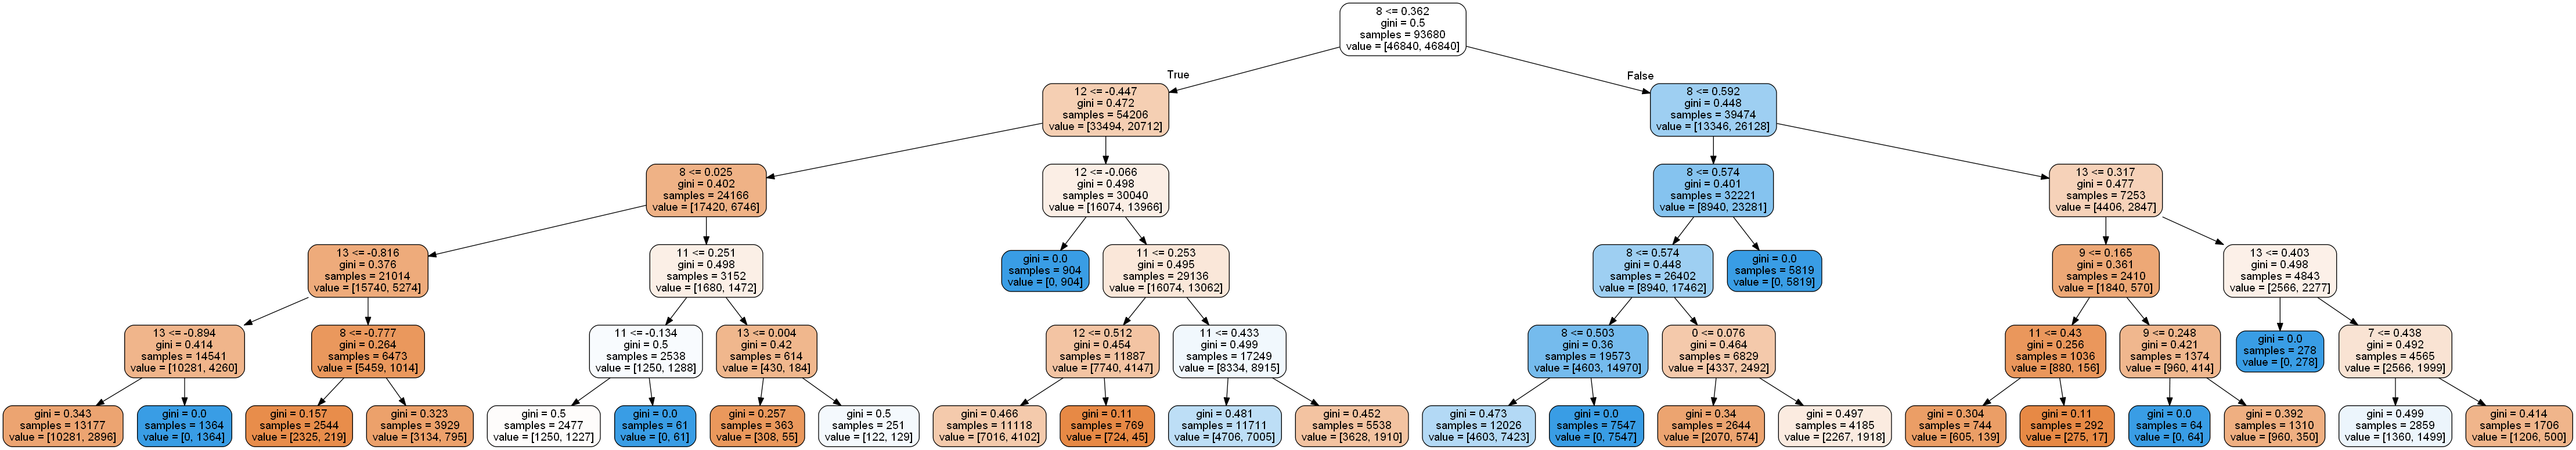

In [107]:
# plotting the graph
dot_data = StringIO()  
export_graphviz(dt_default, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [132]:
# trying model with max_depth=8
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=8, 
                                  min_samples_leaf=50,
                                  min_samples_split=100)
clf_gini.fit(credx_train, def_train)

# accuracy score
clf_gini.score(credx_test,def_test)

0.9379770992366412

In [133]:
# fitting the test data 

# Making predictions
def_pred_dt = clf_gini.predict(credx_test)

# Printing classification report
print(classification_report(def_test, def_pred_dt))

# confusion matrix
print(confusion_matrix(def_test,def_pred_dt))

# sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(def_test, def_pred_dt, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     20077
         1.0       0.05      0.02      0.03       883

   micro avg       0.94      0.94      0.94     20960
   macro avg       0.50      0.50      0.50     20960
weighted avg       0.92      0.94      0.93     20960

[[19638   439]
 [  861    22]]
Sensitivity: 	0.02
Specificity: 	0.98


In [134]:
# trying model with max_depth=6
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=6, 
                                  min_samples_leaf=50,
                                  min_samples_split=100)
clf_gini.fit(credx_train, def_train)

# accuracy score
clf_gini.score(credx_test,def_test)

0.8481393129770992

In [135]:
# fitting the test data 

# Making predictions
def_pred_dt = clf_gini.predict(credx_test)

# Printing classification report
print(classification_report(def_test, def_pred_dt))

# confusion matrix
print(confusion_matrix(def_test,def_pred_dt))

# sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(def_test, def_pred_dt, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92     20077
         1.0       0.04      0.13      0.07       883

   micro avg       0.85      0.85      0.85     20960
   macro avg       0.50      0.50      0.49     20960
weighted avg       0.92      0.85      0.88     20960

[[17666  2411]
 [  772   111]]
Sensitivity: 	0.13
Specificity: 	0.88


In [136]:
# trying model with max_depth=3
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=3, 
                                  min_samples_leaf=50,
                                  min_samples_split=100)
clf_gini.fit(credx_train, def_train)

# accuracy score
clf_gini.score(credx_test,def_test)

0.7909828244274809

In [137]:
# fitting the test data 

# Making predictions
def_pred_dt = clf_gini.predict(credx_test)

# Printing classification report
print(classification_report(def_test, def_pred_dt))

# confusion matrix
print(confusion_matrix(def_test,def_pred_dt))

# sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(def_test, def_pred_dt, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

              precision    recall  f1-score   support

         0.0       0.97      0.81      0.88     20077
         1.0       0.07      0.35      0.12       883

   micro avg       0.79      0.79      0.79     20960
   macro avg       0.52      0.58      0.50     20960
weighted avg       0.93      0.79      0.85     20960

[[16273  3804]
 [  577   306]]
Sensitivity: 	0.35
Specificity: 	0.81


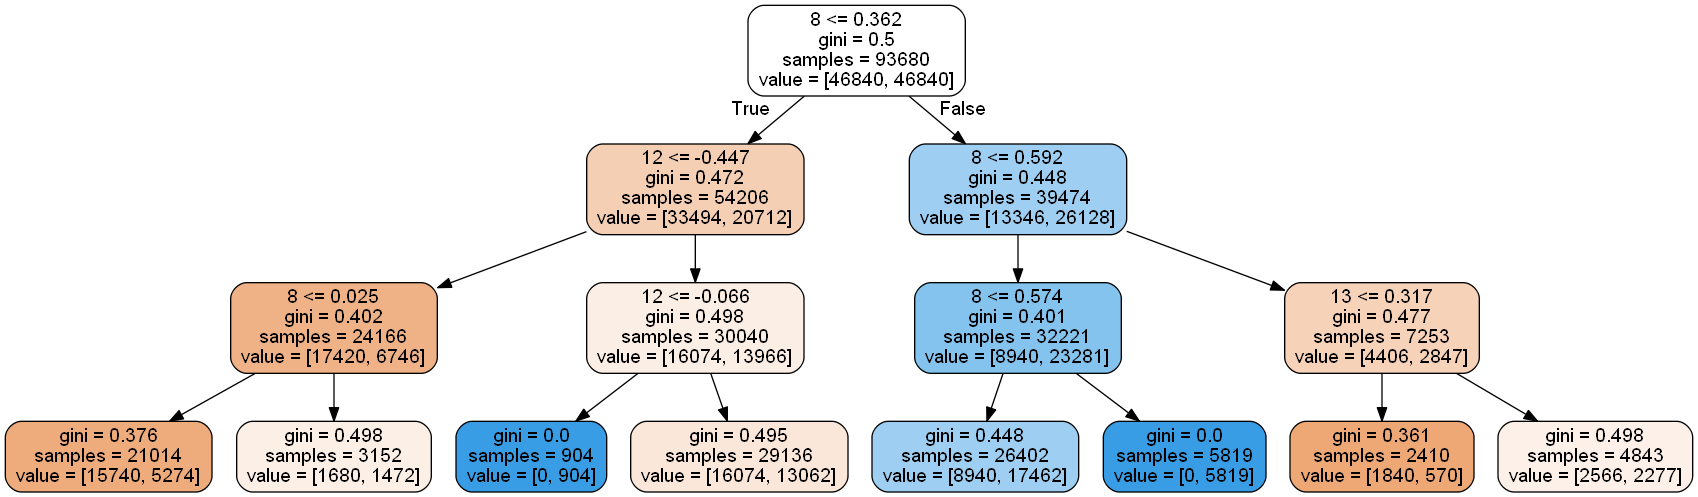

In [138]:
# plotting the graph
dot_data = StringIO()  
export_graphviz(clf_gini, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

As we can see that max_depth=3 is the best combination of the hyperparameters. Let's move on to the Random forst classifier. 

#### Random Forest Classifier

In [139]:
# Running the random forest with default parameters.
rfc = RandomForestClassifier()

# fit model
rfc.fit(credx_train, def_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [140]:
# predicting churn on the test data
def_pred = rfc.predict(credx_test)

In [141]:
# Let's check the report of our default model
print(classification_report(def_test,def_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97     20077
         1.0       0.04      0.02      0.03       883

   micro avg       0.94      0.94      0.94     20960
   macro avg       0.50      0.50      0.50     20960
weighted avg       0.92      0.94      0.93     20960



In [142]:
# confusion matrix
print(confusion_matrix(def_test,def_pred))

# accuracy score
print(accuracy_score(def_test,def_pred))

[[19691   386]
 [  866    17]]
0.940267175572519


In [149]:
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'brier_score_loss',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'mutual_info_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'v_measure_score']

In [152]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [3,4,5],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [100,200, 300], 
    'max_features': [3, 5, 7]
}
# Create a base model
rf = RandomForestClassifier()
# Instantiate the grid-search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, scoring=['accuracy', 'recall'], refit='recall', 
                          cv = 3, n_jobs = -1,verbose = 1)

In [153]:
# Fit the grid-search to data
grid_search.fit(credx_train, def_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 32.5min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed: 63.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [3, 4, 5], 'min_samples_leaf': range(100, 400, 200), 'min_samples_split': range(200, 500, 200), 'n_estimators': [100, 200, 300], 'max_features': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit='recall', return_train_score='warn',
       scoring=['accuracy', 'recall'], verbose=1)

In [154]:
# print the optimal accuracy score and hyperparameters
print('We can get an accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get an accuracy of 0.7726729291204099 using {'max_depth': 5, 'max_features': 7, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 100}


In [155]:
# model with the best hyperparameters
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=100, 
                             min_samples_split=200,
                             max_features=7,
                             n_estimators=100)

In [156]:
# model fit
rfc.fit(credx_train,def_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=200,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [157]:
# predict
preds = rfc.predict(credx_test)

In [158]:
print(classification_report(def_test,preds))

              precision    recall  f1-score   support

         0.0       0.96      0.82      0.89     20077
         1.0       0.07      0.29      0.11       883

   micro avg       0.80      0.80      0.80     20960
   macro avg       0.51      0.56      0.50     20960
weighted avg       0.93      0.80      0.85     20960



In [159]:
# confusion matrix
print(confusion_matrix(def_test,preds))

# accuracy score
print(accuracy_score(def_test,preds))

# sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(def_test, preds, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

[[16447  3630]
 [  625   258]]
0.7969942748091603
Sensitivity: 	0.29
Specificity: 	0.82


And this is the best model we have got! Let's move on and check the model performance on the Rejected population, but before that we will need to convert the data into woe values. 

### Check the model's predictability on the rejected population

In [160]:
# import the rejected data
rejects_df = pd.read_csv("rejects.csv", sep=",")

rejects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 29 columns):
application_id                      1425 non-null int64
age                                 1425 non-null int64
gender                              1425 non-null object
marital_status                      1425 non-null object
noof_dependents                     1425 non-null float64
income                              1425 non-null float64
education                           1424 non-null object
profession                          1425 non-null object
residence_type                      1425 non-null object
noof_months_in_current_residence    1425 non-null int64
noof_months_in_current_company      1425 non-null int64
90DPD_6months                       1425 non-null int64
60DPD_6months                       1425 non-null int64
30DPD_6months                       1425 non-null int64
90DPD_12months                      1425 non-null int64
60DPD_12months                      1425 non

In [163]:
# remove the target column
rejects_df.drop('defaulted', inplace=True, axis=1)

# replace missing value in education with 10
rejects_df['education'].fillna('10', inplace=True)

rejects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 28 columns):
application_id                      1425 non-null int64
age                                 1425 non-null int64
gender                              1425 non-null object
marital_status                      1425 non-null object
noof_dependents                     1425 non-null float64
income                              1425 non-null float64
education                           1425 non-null object
profession                          1425 non-null object
residence_type                      1425 non-null object
noof_months_in_current_residence    1425 non-null int64
noof_months_in_current_company      1425 non-null int64
90DPD_6months                       1425 non-null int64
60DPD_6months                       1425 non-null int64
30DPD_6months                       1425 non-null int64
90DPD_12months                      1425 non-null int64
60DPD_12months                      1425 non

In [164]:
# importing the woe dataframe
credx_woe = pd.read_csv("credx_woe.csv", sep=",")

credx_woe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 10 columns):
Variable           188 non-null object
Cutoff             188 non-null object
Maxval             188 non-null object
N                  188 non-null int64
Events             188 non-null float64
Events_Rate        188 non-null float64
Non-Events         188 non-null float64
Non-Events_Rate    188 non-null float64
WoE                188 non-null float64
IV                 188 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 14.8+ KB


In [165]:
# fetching the list of variables to be transformed
trans_var_list = credx_train.columns

# creating an empty dataframe for woe values imputed
rejects_woe_df = pd.DataFrame()

# imputing the woe values with the resultant dataframe into a new dataframe
for var in trans_var_list:
    small_credx_df = credx_woe[credx_woe['Variable'] == var]
    trans_dict = dict(zip(small_credx_df.Maxval,small_credx_df.WoE))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(trans_dict.items()):
        replace_cmd = replace_cmd + str(i[1]) + str(' if x <= ') + str(i[0]) + ' else '
        replace_cmd1 = replace_cmd1 + str(i[1]) + str(' if x == "') + str(i[0]) + '" else '
    replace_cmd = replace_cmd + '0'
    replace_cmd1 = replace_cmd1 + '0'
    if replace_cmd != '0':
        try:
            rejects_woe_df[var] = rejects_df[var].apply(lambda x: eval(replace_cmd))
        except:
            rejects_woe_df[var] = rejects_df[var].apply(lambda x: eval(replace_cmd1))

In [166]:
# checking the resultant dataframe
rejects_woe_df.head()

,30DPD_12months,30DPD_6months,60DPD_12months,60DPD_6months,90DPD_12months,90DPD_6months,PLtrades_opened_12months,PLtrades_opened_6months,avg_ccutil_12months,inquiries_12months,inquiries_6months,outstanding_balance,total_trades,trades_opened_12months,trades_opened_6months
0,0.738672,0.666972,0.612661,-0.336371,0.508779,-0.260685,0.100907,0.423571,0.36224,0.034536,-0.116135,0.403683,0.375911,0.403396,-0.000353
1,0.592071,0.464274,0.612661,0.541346,0.885508,0.586843,0.100907,0.423571,0.36224,0.034536,-0.116135,0.403683,0.489204,0.484127,-0.000353
2,0.937206,1.046135,0.814540,0.867333,0.885508,1.037804,0.100907,0.438391,0.36224,0.034536,-0.320076,0.403683,0.489204,0.484127,-0.000353
3,0.972734,0.951744,0.884487,0.933733,0.885508,0.586843,0.100907,0.199395,0.36224,0.034536,-0.116135,0.403683,0.489204,0.484127,-0.000353
4,0.937206,0.951744,0.612661,0.668430,0.885508,0.810130,0.100907,0.438391,0.36224,0.034536,-0.116135,0.403683,0.489204,0.484127,-0.000353


In [168]:
# checking the Null values are converted to zero only
rejects_woe_df.astype(bool).sum(axis=0)

30DPD_12months              1425
30DPD_6months               1425
60DPD_12months              1425
60DPD_6months               1425
90DPD_12months              1425
90DPD_6months               1425
PLtrades_opened_12months    1425
PLtrades_opened_6months     1425
avg_ccutil_12months         1390
inquiries_12months          1425
inquiries_6months           1425
outstanding_balance         1425
total_trades                1425
trades_opened_12months      1425
trades_opened_6months       1425
dtype: int64

In [169]:
# imputing the zeros(actually NULLs) in avg_ccutil_12months with their woe values calculated in the previous workbook
rejects_woe_df.loc[rejects_woe_df['avg_ccutil_12months']==0, ['avg_ccutil_12months']] = 0.111429

In [170]:
# predict default
rej_pred = rfc.predict(rejects_woe_df)

In [176]:
print("The rejected dataset have ", sum(rej_pred), " defaulters out of the total ", len(rej_pred), " applicants.")

The rejected dataset have  1353.0  defaulters out of the total  1425  applicants.


Therefore, according to our model 95% applicants are likely to default if issued a Credit card.

## Application Scorecard

### For Approved population

In [190]:
# fetching probability of non-default
app_scorecard_acc = pd.DataFrame(rfc.predict_proba(credx_final_df.drop("defaulted", axis = 1))[:, 0], columns = ['pred_prob_ndef'])
app_scorecard_acc

,pred_prob_ndef
0,0.848895
1,0.787517
2,0.794247
3,0.640137
4,0.762773
5,0.741174
6,0.762773
7,0.767172
8,0.797240
9,0.751221


In [191]:
# calculating the odds of good(non-default)
app_scorecard_acc['odds_ndef'] = app_scorecard_acc['pred_prob_ndef']/(1-app_scorecard_acc['pred_prob_ndef'])
app_scorecard_acc

,pred_prob_ndef,odds_ndef
0,0.848895,5.617932
1,0.787517,3.706261
2,0.794247,3.860196
3,0.640137,1.778836
4,0.762773,3.215373
5,0.741174,2.863593
6,0.762773,3.215373
7,0.767172,3.295015
8,0.797240,3.931936
9,0.751221,3.019631


In [192]:
# calculate log of odds
app_scorecard_acc['log_odds_ndef'] = np.log(app_scorecard_acc['odds_ndef'])
app_scorecard_acc

,pred_prob_ndef,odds_ndef,log_odds_ndef
0,0.848895,5.617932,1.725964
1,0.787517,3.706261,1.310024
2,0.794247,3.860196,1.350718
3,0.640137,1.778836,0.575959
4,0.762773,3.215373,1.167943
5,0.741174,2.863593,1.052077
6,0.762773,3.215373,1.167943
7,0.767172,3.295015,1.192411
8,0.797240,3.931936,1.369132
9,0.751221,3.019631,1.105135


Now, when we have the log(odds), the next step is calculating the Factor and Offset; according to the problem statement, our target score is 400, with the target odds 10 doubling every 20 points, therefore, 

`Factor = 20/ln(2) = 28.853901`                 
`Offset = 400 - 28.853901 * ln(10) = 333.561438`         

And hence, our score can be calculated as,               
`Score = Offset + Factor * log(odds)`

In [193]:
app_scorecard_acc['score'] = 333.561438 + (28.853901 * app_scorecard_acc['log_odds_ndef'])
app_scorecard_acc

,pred_prob_ndef,odds_ndef,log_odds_ndef,score
0,0.848895,5.617932,1.725964,383.362220
1,0.787517,3.706261,1.310024,371.360727
2,0.794247,3.860196,1.350718,372.534924
3,0.640137,1.778836,0.575959,350.180102
4,0.762773,3.215373,1.167943,367.261156
5,0.741174,2.863593,1.052077,363.917969
6,0.762773,3.215373,1.167943,367.261156
7,0.767172,3.295015,1.192411,367.967143
8,0.797240,3.931936,1.369132,373.066236
9,0.751221,3.019631,1.105135,365.448880


In [194]:
print("Maximum score from the approved population is ", app_scorecard_acc['score'].max())
print("Minimum score from the approved population is ", app_scorecard_acc['score'].min())

Maximum score from the approved population is  384.8466698681364
Minimum score from the approved population is  312.61269210395506


### For Rejected population

In [195]:
# fetching probability of non-default
app_scorecard_rej = pd.DataFrame(rfc.predict_proba(rejects_woe_df)[:, 0], columns = ['pred_prob_ndef'])

# calculating the odds of good(non-default)
app_scorecard_rej['odds_ndef'] = app_scorecard_rej['pred_prob_ndef']/(1-app_scorecard_rej['pred_prob_ndef'])

# calculate log of odds
app_scorecard_rej['log_odds_ndef'] = np.log(app_scorecard_rej['odds_ndef'])

app_scorecard_rej['score'] = 333.561438 + (28.853901 * app_scorecard_rej['log_odds_ndef'])
app_scorecard_rej

,pred_prob_ndef,odds_ndef,log_odds_ndef,score
0,0.469249,0.884122,-0.123160,330.007801
1,0.453328,0.829252,-0.187232,328.159071
2,0.457848,0.844501,-0.169010,328.684847
3,0.434492,0.768320,-0.263549,325.957030
4,0.457848,0.844501,-0.169010,328.684847
5,0.436507,0.774646,-0.255350,326.193603
6,0.435808,0.772446,-0.258193,326.111570
7,0.460376,0.853142,-0.158830,328.978586
8,0.434492,0.768320,-0.263549,325.957030
9,0.439058,0.782716,-0.244985,326.492651


In [196]:
print("Maximum score from the rejected population is ", app_scorecard_rej['score'].max())
print("Minimum score from the rejected population is ", app_scorecard_rej['score'].min())

Maximum score from the rejected population is  339.97665614428547
Minimum score from the rejected population is  325.00822331572397


As we can very clearly see from the above scorecards, While the `accepted population's scores are ranging from 312 to 385`, the `rejected population have the maximum score of 340`. Let's compare our model's predictions of default and the individual scores. 

In [198]:
# predicting the default on the accepted population and adding to the scorecard
app_scorecard_acc['pred_default'] = rfc.predict(credx_final_df.drop("defaulted", axis = 1))

# adding the predicted default on the rejected population to the scorecard
app_scorecard_rej['pred_default'] = rej_pred

In [199]:
app_scorecard_acc.head()

,pred_prob_ndef,odds_ndef,log_odds_ndef,score,pred_default
0,0.848895,5.617932,1.725964,383.362220,0.0
1,0.787517,3.706261,1.310024,371.360727,0.0
2,0.794247,3.860196,1.350718,372.534924,0.0
3,0.640137,1.778836,0.575959,350.180102,0.0
4,0.762773,3.215373,1.167943,367.261156,0.0


In [200]:
app_scorecard_rej.head()

,pred_prob_ndef,odds_ndef,log_odds_ndef,score,pred_default
0,0.469249,0.884122,-0.123160,330.007801,1.0
1,0.453328,0.829252,-0.187232,328.159071,1.0
2,0.457848,0.844501,-0.169010,328.684847,1.0
3,0.434492,0.768320,-0.263549,325.957030,1.0
4,0.457848,0.844501,-0.169010,328.684847,1.0


In [201]:
# total predicted defaulters from accepted candidates
app_scorecard_acc['pred_default'].sum()

13045.0

In [204]:
# total predicted non-defaulters from rejected candidates
app_scorecard_rej.loc[app_scorecard_rej['pred_default']==0, ['score']].count()

score    72
dtype: int64

Therefore, there are 13045(which is `~18%`) accepted candidates out of 69864 who `are likely to default`, while 72(which is `5%`) rejected candidates from total of 1425 who `are non-defaulters` according to our model. 

Let's see how their scores speaks,

In [206]:
print("Max score of predicted defaulters from accepted candidates is ", app_scorecard_acc.loc[app_scorecard_acc['pred_default']==1, ['score']].max())
print("Min score of predicted defaulters from accepted candidates is ", app_scorecard_acc.loc[app_scorecard_acc['pred_default']==1, ['score']].min())

Max score of predicted defaulters from accepted candidates is  score    333.561037
dtype: float64
Min score of predicted defaulters from accepted candidates is  score    312.612692
dtype: float64


In [256]:
print("Max score of predicted non-defaulters from rejected candidates is ", app_scorecard_rej.loc[app_scorecard_rej['pred_default']==0, ['score']].max())
print("Min score of predicted non-defaulters from rejected candidates is ", app_scorecard_rej.loc[app_scorecard_rej['pred_default']==0, ['score']].min())

Max score of predicted non-defaulters from rejected candidates is  score    339.976656
dtype: float64
Min score of predicted non-defaulters from rejected candidates is  score    333.593244
dtype: float64


As we just saw that there is a clash between the defaulters and non-defaulters being predicted by our model with the scores ranging between 333-334.  

Looking at the various permutations and combinations, it is probably difficult to predict the default by the model for the `candidates with scores ranging between 332-335` and should better `be reviewed by the Approvals' team`.

**And the cut-off score therefore should be 335.**

## Financial benefit assessment

Let's start with deriving the standard loss and profit per customer based on their category(defaulter/non-defaulter) on the actual data.

In [234]:
# importing the dataframe from previous workbook for financial analysis
credx_finance = pd.read_csv("credx_finance.csv", sep=",")

credx_finance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69864 entries, 0 to 69863
Data columns (total 5 columns):
90DPD_12months         69864 non-null int64
60DPD_12months         69864 non-null int64
30DPD_12months         69864 non-null int64
outstanding_balance    69592 non-null float64
defaulted              69864 non-null float64
dtypes: float64(2), int64(3)
memory usage: 2.7 MB


In [241]:
# dropping the rows with NULL values
credx_finance.fillna(0, inplace=True)

In [243]:
# checking the average outstanding balance of defaulters
round(credx_finance.loc[credx_finance['defaulted']==1, ['outstanding_balance']].mean(), 2)

outstanding_balance    1257205.37
dtype: float64

Whoah! the average outstanding balance per defaulter is ~12.6 lakhs, `let's assume 30% of this amount is recovered` and therefore the **average credit loss per default will be Rs. 880044**.

In [244]:
# checking the total outstanding balance of non-defaulters who have delayed their payment atleast once in past 12 months
credx_finance[(credx_finance['defaulted']==0) & (credx_finance['90DPD_12months'] + credx_finance['60DPD_12months'] + credx_finance['30DPD_12months'] >0)]['outstanding_balance'].sum()

32217560675.0

Again the total outstanding balance of non-defaulters who have made late payment(s) atleast once in last 1 year is 32.2 billions, `assuming that after deducting the expenses the company gain 8% of total outstanding balance as interest income`, which brings us to the **total gain of Rs. 2,577,404,854**.

In [245]:
# getting the distribution of the data
credx_finance['defaulted'].value_counts(dropna=False)

0.0    66917
1.0     2947
Name: defaulted, dtype: int64

 So, the gain per non-defaulter is Rs. 38,516
 
 And the **total credit loss** to the company from defaulters is Rs. (880044 * 2947) = **Rs. 2,593,489,668**

In [246]:
# adding the predicted default to the financial analysis
credx_finance['pred_default'] = app_scorecard_acc['pred_default']
credx_finance.head()

,90DPD_12months,60DPD_12months,30DPD_12months,outstanding_balance,defaulted,pred_default
0,0,0,0,2999395.0,0.0,0.0
1,0,0,0,3078.0,0.0,0.0
2,0,0,0,3004972.0,0.0,0.0
3,0,0,0,3355373.0,0.0,0.0
4,0,0,0,3014283.0,0.0,0.0


In [249]:
# calculate the no of defaulters reported right by the model
credx_finance[(credx_finance['defaulted']==1) & (credx_finance['pred_default']==1)]['defaulted'].count()

905

In [250]:
# calculate the no of defaulters reported wrong by the model
credx_finance[(credx_finance['defaulted']==1) & (credx_finance['pred_default']==0)]['defaulted'].count()

2042

In [251]:
# calculate the no of non-defaulters reported wrong by the model
credx_finance[(credx_finance['defaulted']==0) & (credx_finance['pred_default']==1)]['pred_default'].count()

12140

So, there are 905 defaulters which are thrown out by the model `saving` the company Rs.(905 * 880044) = `Rs.796,439,820`.     
Also there are 12140 non-defaulters which are thrown out by the model incurring a `loss of interest` Rs.(12140 * 38516) = `Rs.467,584,240`. 

Therefore if **using the model for auto approval/rejection we save Rs.328,855,580**, in other words we cut 18% of the loss.

*`Whereas, we can further reduce the loss by reveiwing the candidates with scores between 340-325`*. 